In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.image as mpimg


import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image


In [2]:
dev = None
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

In [3]:
device

device(type='cuda', index=0)

In [4]:
# Parameters
batch_size = 64
image_size = 64

eps=1e-7
# z_size = 50
# ngf=32
# nc = 1

# Root directory for dataset
dataroot = "./pokemon"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 128

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Dataset

In [5]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = [img for img in os.listdir(main_dir) if img.lower().endswith(".png") and "-back-" not in img]
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image


In [6]:
transform = transforms.Compose(
    [transforms.Resize(image_size), transforms.CenterCrop(image_size), transforms.RandomHorizontalFlip(), transforms.RandomAdjustSharpness(sharpness_factor=2), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
)
# Try a few different normalizations
# and make sure generators output to the same range, then generator doesn't have to learn range

In [7]:
img_folder_path = "./pokemon"

In [8]:
my_dataset = CustomDataSet(img_folder_path, transform=transform)
trainloader = torch.utils.data.DataLoader(my_dataset , batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=True)


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


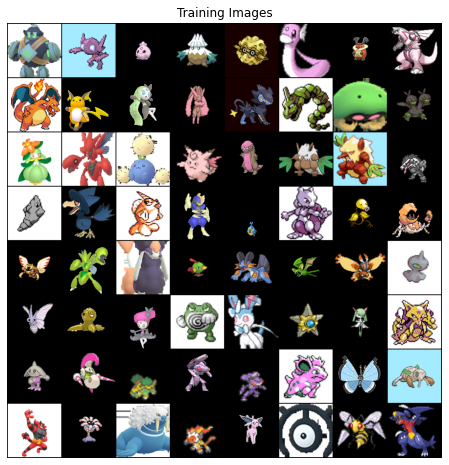

In [9]:
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
# valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [11]:
len(trainloader)

371

# Networks

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class DiscriminatorConvNet(nn.Module):    
    def __init__(self):
        super(DiscriminatorConvNet, self).__init__()

        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten(start_dim=1)
        )
    

    def forward(self, x):
        return self.main(x)

D = DiscriminatorConvNet().to(device)
# D.apply(weights_init)
D

DiscriminatorConvNet(
  (main): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(204

In [14]:
# test input
inp = torch.randn(2,nc,image_size,image_size).to(device)
d_out = D(inp)
print(d_out)
d_image_out = D(real_batch.to(device))
print(d_image_out.shape)

tensor([[0.4446],
        [0.4706]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
torch.Size([64, 1])


# Define the generator network

In [15]:
class GeneratorConvNet(nn.Module):
    def __init__(self):
        super(GeneratorConvNet, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, x):
        return self.main(x)

G = GeneratorConvNet().to(device)
# G.apply(weights_init)
G

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [16]:
# test input
inp = torch.randn(2, nz, 1, 1).to(device)
g_out = G(inp)
print(g_out.shape)

torch.Size([2, 3, 128, 128])


In [18]:
# Try running G out through D
d_of_g_out = D(g_out)
print(d_of_g_out)

tensor([[0.5077],
        [0.5072]], grad_fn=<SigmoidBackward0>)


In [17]:
noise_generator = lambda x: torch.FloatTensor(x, nz, 1, 1).uniform_(0, 1) # pg(z) torch.randn(x, z_size)
noise_generator(2).shape

torch.Size([2, 100, 1, 1])

# Train algorithm

In [19]:
# Define the train parameters
# num_epochs = 12
# batch_size = 128
k_steps = 1
num_val_batches = 10


In [20]:
dataloader = trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=batch_size, shuffle=True, 
                               num_workers=4, drop_last=True)

#pdata(x)
# train_real_sampler = iter(trainloader)
# val_real_sampler = train_real_sampler

In [21]:
# pg(z)
noise_generator = lambda x: torch.FloatTensor(x, nz, 1, 1).to(device)
noise_generator(2).shape

torch.Size([2, 100, 1, 1])

In [22]:
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
D.to(device)
G.to(device)

# G.apply(weights_init)
# D.apply(weights_init)

GeneratorConvNet(
  (main): Sequential(
    (0): ConvTranspose2d(100, 2048, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (

In [24]:
criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

fixed_noise = torch.randn(64, nz, 1, 1, device=device)


In [25]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
broke = False

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if epoch > 15 and 0.48 <= D_x <= 0.52 and 0.48 <= D_G_z2 <= 0.52: 
            broke = True
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            break

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
    if broke: break

Starting Training Loop...


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[0/20][0/371]	Loss_D: 1.3822	Loss_G: 19.2956	D(x): 0.5340	D(G(z)): 0.5188 / 0.0000
[0/20][50/371]	Loss_D: 2.3840	Loss_G: 1.0997	D(x): 0.1959	D(G(z)): 0.0416 / 0.3889
[0/20][100/371]	Loss_D: 1.0571	Loss_G: 1.8343	D(x): 0.7263	D(G(z)): 0.4626 / 0.1832
[0/20][150/371]	Loss_D: 1.3548	Loss_G: 2.3644	D(x): 0.7078	D(G(z)): 0.5438 / 0.1593
[0/20][200/371]	Loss_D: 1.2049	Loss_G: 2.2593	D(x): 0.7068	D(G(z)): 0.4548 / 0.1656
[0/20][250/371]	Loss_D: 1.0975	Loss_G: 1.7098	D(x): 0.6161	D(G(z)): 0.3369 / 0.2298
[0/20][300/371]	Loss_D: 0.9890	Loss_G: 2.2806	D(x): 0.7112	D(G(z)): 0.4289 / 0.1594
[0/20][350/371]	Loss_D: 1.3925	Loss_G: 0.9638	D(x): 0.3639	D(G(z)): 0.2415 / 0.4037


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[1/20][0/371]	Loss_D: 1.6504	Loss_G: 2.0730	D(x): 0.6608	D(G(z)): 0.6535 / 0.1633
[1/20][50/371]	Loss_D: 0.6685	Loss_G: 2.6806	D(x): 0.7155	D(G(z)): 0.2077 / 0.0859
[1/20][100/371]	Loss_D: 0.9546	Loss_G: 4.3825	D(x): 0.7429	D(G(z)): 0.3976 / 0.0187
[1/20][150/371]	Loss_D: 0.5667	Loss_G: 1.9193	D(x): 0.7409	D(G(z)): 0.2040 / 0.1664
[1/20][200/371]	Loss_D: 1.5897	Loss_G: 4.3107	D(x): 0.8410	D(G(z)): 0.6765 / 0.0191
[1/20][250/371]	Loss_D: 1.1356	Loss_G: 3.1640	D(x): 0.5208	D(G(z)): 0.2428 / 0.1102
[1/20][300/371]	Loss_D: 0.7923	Loss_G: 1.8767	D(x): 0.5411	D(G(z)): 0.1103 / 0.1786
[1/20][350/371]	Loss_D: 0.7644	Loss_G: 2.2741	D(x): 0.8383	D(G(z)): 0.3937 / 0.1282


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[2/20][0/371]	Loss_D: 1.9349	Loss_G: 1.6843	D(x): 0.9136	D(G(z)): 0.7697 / 0.2082
[2/20][50/371]	Loss_D: 1.9423	Loss_G: 2.1036	D(x): 0.5708	D(G(z)): 0.5072 / 0.1600
[2/20][100/371]	Loss_D: 1.3867	Loss_G: 1.5765	D(x): 0.7123	D(G(z)): 0.5805 / 0.2921
[2/20][150/371]	Loss_D: 1.0603	Loss_G: 1.5594	D(x): 0.5046	D(G(z)): 0.1731 / 0.2619
[2/20][200/371]	Loss_D: 1.7320	Loss_G: 3.3067	D(x): 0.8257	D(G(z)): 0.6587 / 0.1045
[2/20][250/371]	Loss_D: 0.9198	Loss_G: 2.7508	D(x): 0.8039	D(G(z)): 0.4388 / 0.0916
[2/20][300/371]	Loss_D: 0.5141	Loss_G: 3.1740	D(x): 0.6871	D(G(z)): 0.0965 / 0.0624
[2/20][350/371]	Loss_D: 0.8312	Loss_G: 4.3462	D(x): 0.8617	D(G(z)): 0.4380 / 0.0278


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[3/20][0/371]	Loss_D: 2.0409	Loss_G: 4.3404	D(x): 0.6910	D(G(z)): 0.5436 / 0.0479
[3/20][50/371]	Loss_D: 1.0753	Loss_G: 1.5750	D(x): 0.4477	D(G(z)): 0.1102 / 0.2645
[3/20][100/371]	Loss_D: 0.5291	Loss_G: 2.2274	D(x): 0.6529	D(G(z)): 0.0721 / 0.1340
[3/20][150/371]	Loss_D: 0.8327	Loss_G: 2.1506	D(x): 0.8063	D(G(z)): 0.4213 / 0.1356
[3/20][200/371]	Loss_D: 0.9475	Loss_G: 2.5968	D(x): 0.6160	D(G(z)): 0.0784 / 0.1378
[3/20][250/371]	Loss_D: 1.2988	Loss_G: 4.3425	D(x): 0.9027	D(G(z)): 0.5362 / 0.0306
[3/20][300/371]	Loss_D: 1.0350	Loss_G: 2.5779	D(x): 0.6767	D(G(z)): 0.3813 / 0.1711
[3/20][350/371]	Loss_D: 1.1704	Loss_G: 1.8169	D(x): 0.4515	D(G(z)): 0.1398 / 0.2197


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[4/20][0/371]	Loss_D: 0.9603	Loss_G: 4.2463	D(x): 0.7328	D(G(z)): 0.3349 / 0.0273
[4/20][50/371]	Loss_D: 1.1781	Loss_G: 0.7759	D(x): 0.3843	D(G(z)): 0.0627 / 0.5382
[4/20][100/371]	Loss_D: 1.4467	Loss_G: 3.1558	D(x): 0.9291	D(G(z)): 0.6882 / 0.0671
[4/20][150/371]	Loss_D: 1.0220	Loss_G: 2.7131	D(x): 0.7378	D(G(z)): 0.4241 / 0.1613
[4/20][200/371]	Loss_D: 1.1871	Loss_G: 2.4259	D(x): 0.3857	D(G(z)): 0.0326 / 0.1388
[4/20][250/371]	Loss_D: 0.3810	Loss_G: 2.2860	D(x): 0.7868	D(G(z)): 0.0972 / 0.1267
[4/20][300/371]	Loss_D: 0.3930	Loss_G: 4.2856	D(x): 0.8920	D(G(z)): 0.2111 / 0.0203
[4/20][350/371]	Loss_D: 1.1630	Loss_G: 5.4929	D(x): 0.9226	D(G(z)): 0.5790 / 0.0092


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[5/20][0/371]	Loss_D: 0.2965	Loss_G: 4.7488	D(x): 0.8124	D(G(z)): 0.0631 / 0.0147
[5/20][50/371]	Loss_D: 0.5887	Loss_G: 4.1429	D(x): 0.9130	D(G(z)): 0.3357 / 0.0235
[5/20][100/371]	Loss_D: 0.8336	Loss_G: 2.5409	D(x): 0.8273	D(G(z)): 0.4026 / 0.1119
[5/20][150/371]	Loss_D: 0.6675	Loss_G: 3.8145	D(x): 0.7940	D(G(z)): 0.2940 / 0.0336
[5/20][200/371]	Loss_D: 1.3539	Loss_G: 3.8855	D(x): 0.9051	D(G(z)): 0.5574 / 0.0328
[5/20][250/371]	Loss_D: 0.8120	Loss_G: 3.0996	D(x): 0.5377	D(G(z)): 0.0461 / 0.0781
[5/20][300/371]	Loss_D: 2.0926	Loss_G: 4.4278	D(x): 0.9582	D(G(z)): 0.8009 / 0.0324
[5/20][350/371]	Loss_D: 0.7546	Loss_G: 3.5137	D(x): 0.7082	D(G(z)): 0.2747 / 0.0423


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[6/20][0/371]	Loss_D: 0.6819	Loss_G: 3.5271	D(x): 0.7575	D(G(z)): 0.2599 / 0.0674
[6/20][50/371]	Loss_D: 0.8015	Loss_G: 4.8066	D(x): 0.9005	D(G(z)): 0.4491 / 0.0139
[6/20][100/371]	Loss_D: 0.6282	Loss_G: 3.0871	D(x): 0.7434	D(G(z)): 0.2348 / 0.0714
[6/20][150/371]	Loss_D: 0.4988	Loss_G: 3.9080	D(x): 0.7920	D(G(z)): 0.1950 / 0.0279
[6/20][200/371]	Loss_D: 1.3661	Loss_G: 6.5282	D(x): 0.9098	D(G(z)): 0.6509 / 0.0034
[6/20][250/371]	Loss_D: 0.9657	Loss_G: 2.4432	D(x): 0.5438	D(G(z)): 0.1642 / 0.1355
[6/20][300/371]	Loss_D: 0.3368	Loss_G: 5.1913	D(x): 0.8829	D(G(z)): 0.1665 / 0.0106
[6/20][350/371]	Loss_D: 0.2156	Loss_G: 4.8057	D(x): 0.9249	D(G(z)): 0.1187 / 0.0133


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[7/20][0/371]	Loss_D: 0.5592	Loss_G: 2.7040	D(x): 0.7759	D(G(z)): 0.2109 / 0.0948
[7/20][50/371]	Loss_D: 0.4768	Loss_G: 2.8501	D(x): 0.7998	D(G(z)): 0.1788 / 0.0932
[7/20][100/371]	Loss_D: 0.4386	Loss_G: 3.2990	D(x): 0.7174	D(G(z)): 0.0509 / 0.0534
[7/20][150/371]	Loss_D: 0.5911	Loss_G: 2.6348	D(x): 0.6736	D(G(z)): 0.1330 / 0.1168
[7/20][200/371]	Loss_D: 0.7189	Loss_G: 3.7746	D(x): 0.7230	D(G(z)): 0.2791 / 0.0364
[7/20][250/371]	Loss_D: 0.4769	Loss_G: 3.7412	D(x): 0.9309	D(G(z)): 0.2941 / 0.0344
[7/20][300/371]	Loss_D: 0.4812	Loss_G: 4.0893	D(x): 0.9568	D(G(z)): 0.3242 / 0.0257
[7/20][350/371]	Loss_D: 0.5961	Loss_G: 4.8333	D(x): 0.8632	D(G(z)): 0.3085 / 0.0213


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[8/20][0/371]	Loss_D: 2.1559	Loss_G: 0.5527	D(x): 0.1804	D(G(z)): 0.0191 / 0.6937
[8/20][50/371]	Loss_D: 0.3574	Loss_G: 3.3795	D(x): 0.9543	D(G(z)): 0.2310 / 0.0552
[8/20][100/371]	Loss_D: 2.1031	Loss_G: 10.8114	D(x): 0.9762	D(G(z)): 0.8211 / 0.0001
[8/20][150/371]	Loss_D: 0.3072	Loss_G: 4.1910	D(x): 0.9167	D(G(z)): 0.1754 / 0.0233
[8/20][200/371]	Loss_D: 1.0172	Loss_G: 7.0773	D(x): 0.8860	D(G(z)): 0.5129 / 0.0014
[8/20][250/371]	Loss_D: 0.5832	Loss_G: 3.2775	D(x): 0.6437	D(G(z)): 0.0646 / 0.0619
[8/20][300/371]	Loss_D: 0.3838	Loss_G: 3.8806	D(x): 0.8003	D(G(z)): 0.1160 / 0.0347
[8/20][350/371]	Loss_D: 0.3575	Loss_G: 4.9113	D(x): 0.9756	D(G(z)): 0.2191 / 0.0220


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[9/20][0/371]	Loss_D: 0.5630	Loss_G: 5.8181	D(x): 0.6406	D(G(z)): 0.0068 / 0.0091
[9/20][50/371]	Loss_D: 0.4946	Loss_G: 5.2395	D(x): 0.7429	D(G(z)): 0.0808 / 0.0135
[9/20][100/371]	Loss_D: 0.5239	Loss_G: 3.7610	D(x): 0.8501	D(G(z)): 0.2598 / 0.0345
[9/20][150/371]	Loss_D: 0.1673	Loss_G: 5.9999	D(x): 0.8815	D(G(z)): 0.0304 / 0.0062
[9/20][200/371]	Loss_D: 0.1812	Loss_G: 7.3846	D(x): 0.8662	D(G(z)): 0.0228 / 0.0030
[9/20][250/371]	Loss_D: 0.5147	Loss_G: 2.7246	D(x): 0.8155	D(G(z)): 0.1761 / 0.1291
[9/20][300/371]	Loss_D: 2.7292	Loss_G: 4.0415	D(x): 0.1317	D(G(z)): 0.0008 / 0.0421
[9/20][350/371]	Loss_D: 0.5656	Loss_G: 4.8298	D(x): 0.6453	D(G(z)): 0.0090 / 0.0186


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[10/20][0/371]	Loss_D: 0.2984	Loss_G: 4.9239	D(x): 0.8881	D(G(z)): 0.1451 / 0.0163
[10/20][50/371]	Loss_D: 0.7217	Loss_G: 5.3998	D(x): 0.9696	D(G(z)): 0.4481 / 0.0077
[10/20][100/371]	Loss_D: 0.2405	Loss_G: 4.3681	D(x): 0.9005	D(G(z)): 0.1065 / 0.0201
[10/20][150/371]	Loss_D: 0.6852	Loss_G: 7.0363	D(x): 0.7164	D(G(z)): 0.1529 / 0.0038
[10/20][200/371]	Loss_D: 0.2965	Loss_G: 5.5536	D(x): 0.9768	D(G(z)): 0.2196 / 0.0059
[10/20][250/371]	Loss_D: 0.1136	Loss_G: 3.6614	D(x): 0.9930	D(G(z)): 0.0903 / 0.0418
[10/20][300/371]	Loss_D: 1.0156	Loss_G: 6.8591	D(x): 0.9264	D(G(z)): 0.5368 / 0.0018
[10/20][350/371]	Loss_D: 0.7388	Loss_G: 7.6870	D(x): 0.9066	D(G(z)): 0.3756 / 0.0010


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[11/20][0/371]	Loss_D: 0.2127	Loss_G: 4.1959	D(x): 0.9340	D(G(z)): 0.1194 / 0.0223
[11/20][50/371]	Loss_D: 0.3462	Loss_G: 5.1051	D(x): 0.9089	D(G(z)): 0.1830 / 0.0111
[11/20][100/371]	Loss_D: 0.2744	Loss_G: 4.4955	D(x): 0.8371	D(G(z)): 0.0429 / 0.0224
[11/20][150/371]	Loss_D: 0.1349	Loss_G: 6.4021	D(x): 0.9053	D(G(z)): 0.0216 / 0.0048
[11/20][200/371]	Loss_D: 0.3010	Loss_G: 6.1427	D(x): 0.9743	D(G(z)): 0.1985 / 0.0058
[11/20][250/371]	Loss_D: 0.7502	Loss_G: 4.9010	D(x): 0.7409	D(G(z)): 0.2925 / 0.0140
[11/20][300/371]	Loss_D: 0.9865	Loss_G: 4.9906	D(x): 0.5073	D(G(z)): 0.0040 / 0.0346
[11/20][350/371]	Loss_D: 0.1994	Loss_G: 4.3308	D(x): 0.8755	D(G(z)): 0.0523 / 0.0287


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[12/20][0/371]	Loss_D: 0.2640	Loss_G: 4.7226	D(x): 0.8873	D(G(z)): 0.1015 / 0.0204
[12/20][50/371]	Loss_D: 0.4502	Loss_G: 4.4077	D(x): 0.7371	D(G(z)): 0.0369 / 0.0274
[12/20][100/371]	Loss_D: 0.2734	Loss_G: 6.8448	D(x): 0.7935	D(G(z)): 0.0059 / 0.0032
[12/20][150/371]	Loss_D: 0.2593	Loss_G: 5.1404	D(x): 0.8051	D(G(z)): 0.0206 / 0.0180
[12/20][200/371]	Loss_D: 0.6218	Loss_G: 6.4207	D(x): 0.9224	D(G(z)): 0.3657 / 0.0035
[12/20][250/371]	Loss_D: 0.5662	Loss_G: 8.5815	D(x): 0.9978	D(G(z)): 0.3761 / 0.0004
[12/20][300/371]	Loss_D: 0.2319	Loss_G: 4.5875	D(x): 0.8800	D(G(z)): 0.0802 / 0.0219
[12/20][350/371]	Loss_D: 0.3650	Loss_G: 3.4550	D(x): 0.8451	D(G(z)): 0.1498 / 0.0588


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[13/20][0/371]	Loss_D: 0.3156	Loss_G: 5.5307	D(x): 0.7639	D(G(z)): 0.0047 / 0.0092
[13/20][50/371]	Loss_D: 0.9234	Loss_G: 6.2352	D(x): 0.5065	D(G(z)): 0.0045 / 0.0092
[13/20][100/371]	Loss_D: 0.7306	Loss_G: 6.3713	D(x): 0.8256	D(G(z)): 0.3355 / 0.0066
[13/20][150/371]	Loss_D: 0.2081	Loss_G: 4.4403	D(x): 0.9326	D(G(z)): 0.1151 / 0.0250
[13/20][200/371]	Loss_D: 0.8237	Loss_G: 6.4532	D(x): 0.7183	D(G(z)): 0.1736 / 0.0089
[13/20][250/371]	Loss_D: 0.6058	Loss_G: 7.8515	D(x): 0.9781	D(G(z)): 0.3690 / 0.0015
[13/20][300/371]	Loss_D: 0.0788	Loss_G: 6.5504	D(x): 0.9877	D(G(z)): 0.0557 / 0.0038
[13/20][350/371]	Loss_D: 0.8210	Loss_G: 8.8541	D(x): 0.9971	D(G(z)): 0.4927 / 0.0004


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[14/20][0/371]	Loss_D: 0.2682	Loss_G: 7.0592	D(x): 0.9597	D(G(z)): 0.1835 / 0.0018
[14/20][50/371]	Loss_D: 0.1224	Loss_G: 5.9609	D(x): 0.9422	D(G(z)): 0.0567 / 0.0065
[14/20][100/371]	Loss_D: 0.4117	Loss_G: 6.2427	D(x): 0.8731	D(G(z)): 0.1938 / 0.0138
[14/20][150/371]	Loss_D: 0.2546	Loss_G: 6.3582	D(x): 0.8142	D(G(z)): 0.0138 / 0.0032
[14/20][200/371]	Loss_D: 0.2223	Loss_G: 4.2434	D(x): 0.9212	D(G(z)): 0.1171 / 0.0270
[14/20][250/371]	Loss_D: 0.0818	Loss_G: 2.9179	D(x): 0.9719	D(G(z)): 0.0488 / 0.0922
[14/20][300/371]	Loss_D: 0.1594	Loss_G: 5.3147	D(x): 0.9713	D(G(z)): 0.1095 / 0.0090
[14/20][350/371]	Loss_D: 0.3443	Loss_G: 5.0674	D(x): 0.9962	D(G(z)): 0.2228 / 0.0158


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[15/20][0/371]	Loss_D: 0.3302	Loss_G: 8.6322	D(x): 0.9898	D(G(z)): 0.2353 / 0.0004
[15/20][50/371]	Loss_D: 0.1282	Loss_G: 4.5245	D(x): 0.9486	D(G(z)): 0.0643 / 0.0164
[15/20][100/371]	Loss_D: 1.7100	Loss_G: 11.1563	D(x): 0.9935	D(G(z)): 0.7373 / 0.0001
[15/20][150/371]	Loss_D: 0.3101	Loss_G: 4.1604	D(x): 0.9958	D(G(z)): 0.2265 / 0.0250
[15/20][200/371]	Loss_D: 0.1687	Loss_G: 6.2975	D(x): 0.8709	D(G(z)): 0.0064 / 0.0035
[15/20][250/371]	Loss_D: 0.4292	Loss_G: 3.8825	D(x): 0.8074	D(G(z)): 0.1414 / 0.0608
[15/20][300/371]	Loss_D: 0.4252	Loss_G: 6.5359	D(x): 0.8498	D(G(z)): 0.1880 / 0.0027
[15/20][350/371]	Loss_D: 0.7258	Loss_G: 5.7963	D(x): 0.5410	D(G(z)): 0.0009 / 0.0139


/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


[16/20][0/371]	Loss_D: 0.4365	Loss_G: 1.0686	D(x): 0.7191	D(G(z)): 0.0461 / 0.4350
[16/20][50/371]	Loss_D: 0.0264	Loss_G: 4.1998	D(x): 0.9852	D(G(z)): 0.0108 / 0.0427
[16/20][100/371]	Loss_D: 0.1104	Loss_G: 5.5915	D(x): 0.9761	D(G(z)): 0.0759 / 0.0068
[16/20][114/371]	Loss_D: 1.3312	Loss_G: 1.0005	D(x): 0.5147	D(G(z)): 0.0507 / 0.5099


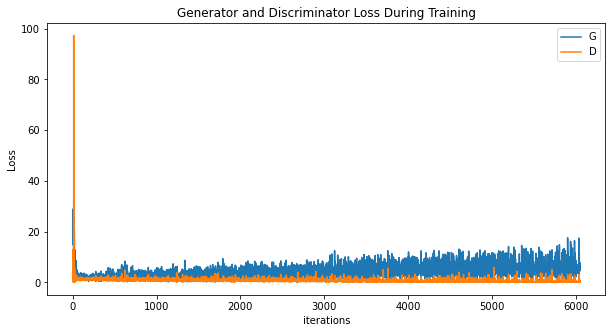

In [26]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

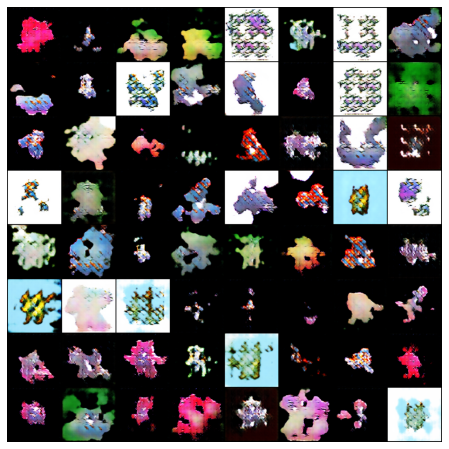

In [27]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/home/tysonbul/miniconda3/envs/gan/lib/python3.7/site-packages/PIL/Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


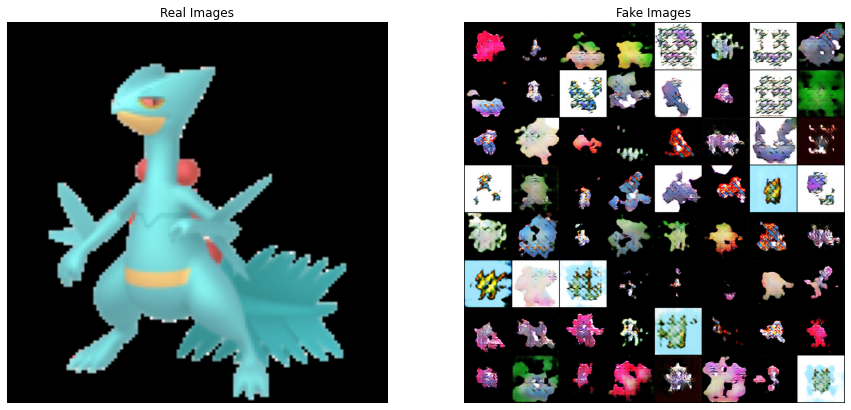

In [28]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


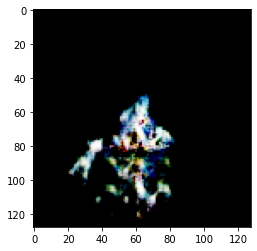

In [99]:
plt.imshow(np.transpose(G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu()[0],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape

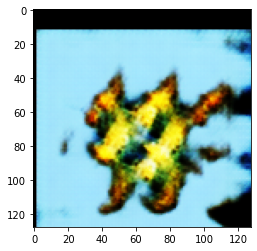

In [90]:
# img_list[-1][:,:64,:64].shape
i = 6
j = 1
plt.imshow(np.transpose(img_list[-1][:,128 * (i-1):128*i,128*(j-1):128*j],(1,2,0)))
plt.show()
# G(torch.randn(b_size, nz, 1, 1, device=device)).detach().cpu().shape